<a href="https://colab.research.google.com/github/sruthi1996/DeepLearning/blob/master/kerasAutodiffMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Automatic  Differentiation**

The method of calculating the partial derivative of an expression at a given point in neural networks is called automatic differentiation or autodiff.




In [0]:
import numpy as np
import matplotlib.pyplot as plt


In [0]:
class Tensor(object):
  def __init__(self,data,creators=None,creation_ops=None):
    self.data = np.array(data)
    self.creation_ops = creation_ops
    self.creators = creators
    self.gradient = None
  def backward(self,gradient):
    self.gradient = gradient
    if (self.creation_ops == 'add'):
      self.creators[0].backward(gradient)
      self.creators[1].backward(gradient)
  def __add__(self,other):
    return Tensor(self.data + other.data,creators=[self,other],creation_ops="add")
  def __repr__(self):
    return str(self.data.__repr__())
  def __str__(self):
    return str(self.data.__str__())


In [0]:
x = Tensor([1,2,3,4,5])
y = Tensor([5,5,5,5,5])

In [0]:
z = y + y


In [8]:
z

array([10, 10, 10, 10, 10])

In [9]:
print(x.gradient)

None


In [10]:
a = Tensor([1,2,3,4,5])
b = Tensor([2,2,2,2,2])
c = Tensor([5,4,3,2,1])
d = Tensor([-1,-2,-3,-4,-5])

e = a + b
f = c + d
g = e + f
g.backward(Tensor(np.array([1,1,1,1,1])))

print(a.gradient)

[1 1 1 1 1]


In [0]:
 class Tensor:

    def __init__(self, data, requires_gradient=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        self.requires_gradient = requires_gradient
        # tensor gradient
        self._gradient = None
        self._gradient_fn = None

    @property
    def shape(self):
        return self.data.shape

    @property
    def gradient_fn(self):
        if not self.requires_gradient:
            raise Exception('No backpropagation of this tensor')
        return self._gradient_fn

    @property
    def gradient(self):
        return self._gradient

    def backward(self, gradient=None):
        if not self.gradient_fn:
            return False

        if gradient is None and self._grad is None:
            gradient = self.__class__(1., requires_grad=False)

        elif self.gradient is not None:
            gradient = self._grad

        if not self.requires_gradient:
            raise Exception('No backpropagation of this tensor')

        self.gradient_fn.backward(grad)
        return True

    def __str__(self):
        return f'Tensor({str(self.data)})'

    def add_gradient(self, grad):
        if self._gradient is None:
            self._gradient = gradient
        else:
            self._gradient += gradient

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

class Op:

    def forward(self):
        raise NotImplemented

    def backward(self, gradient):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._gradient_fn = self
        return self.out


class AddOp(Op):

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        requires_gradient = x.requires_gradient or y.requires_gradient
        return Tensor(x.data + y.data, requires_gradient=requires_gradient)

    def backward(self, gradient):
        if self.x.requires_gradient:
            # as we have matrix operation one of the parameters can 
            # have partial shape in such scenarion we need to sum
            # gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - 
                                 np.array(gradient.shape)))
                self.x.add_grad(Tensor(gradient.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.x.add_grad(gradient)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_gradient:
            if self.y.shape != gradient.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - 
                                        np.array(gradient.shape)))
                self.y.add_gradient(Tensor(gradient.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.y.add_gradient(gradient)
            if self.y.gradient_fn:
                self.y.backward()


#multiplication with 2 tensors
class MulOp(Op): 

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        requires_gradient = x.requires_grad or y.requires_grad
        return Tensor(x.data * y.data, requires_gradient=requires_gradient)

    def backward(self, gradient):
        if self.x.requires_gradient:
            print(self.x, self.x._gradient, gradient)
            self.x.add_gradient(Tensor(gradient.data * self.y.data, False))
            if self.x.gradient_fn:
                self.x.backward()
        if self.y.requires_gradient:
            self.y.add_gradient(Tensor(gradient.data * self.x.data, False))
            if self.y.gradient_fn:
                self.y.backward()

In [0]:
class Layer:

    def forward(self):
        raise NotImplemented

    def backward(self, gradient):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid:

    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))

    def backward(self, gradient):
        gradient_input = self.x*(1-self.x) * grad
        return gradient_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)

    def backward(self, gradient):
        gradient_input = (self.x > 0) * gradient
        return gradient_input

class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss

    def backward(self, gradient=None):
        batch = self.x.shape[0]
        gradient = self.softmax
        gradient[np.arange(batch),self.y] -= 1
        gradient = gradient/batch
        return gradient

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, gradient=None):
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr

    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, gradient):
        # d_layer / db = 1
        b_gradient = gradient.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_gradient = np.dot(self.x.T, gradient)
        gradient_input = np.dot(gradient, self.A.T)

        self.A -= A_gradient * self.lr
        self.b -= b_gradient * self.lr

        return gradient_input

Implementing on MNIST dataset using  torchvision dataset repo

3.0406438020113966
---------
210.36813136522088
---------
214.16074152116468
---------
173.39421013757652
---------
174.34006120333174
---------
195.3983762390813
---------
155.1345504043538
---------
158.35158132887562
---------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


inf
---------
inf
---------
136.3880407398569
---------
135.87159109131346
---------
146.70930319670305
---------
142.5709123408937
---------
135.1529927428306
---------
inf
---------
106.45701721289579
---------
119.87803916342604
---------
110.86337233114403
---------
130.32084120451046
---------
114.30662258260949
---------
115.612156754047
---------
125.21760070184312
---------
121.86082579140967
---------
115.2338453519162
---------
120.6141109720195
---------
107.34354428957144
---------
105.34722107750558
---------
96.86676431398637
---------
82.3018547338522
---------
101.8000877613138
---------
89.38959017932554
---------
85.2126843576158
---------
79.6533407782085
---------
80.46044880204887
---------
89.59950456892076
---------
79.3354681099035
---------
84.50280866542226
---------
83.16863659462545
---------
89.29141435370695
---------
72.31632782781774
---------
74.83405071114467
---------
87.60406483275528
---------
74.64731042814803
---------
77.00361341373093
---------


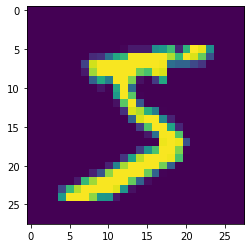

target: 5 predicted: 5


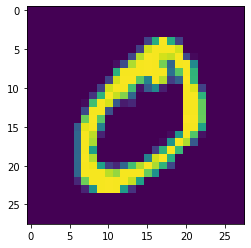

target: 0 predicted: 0


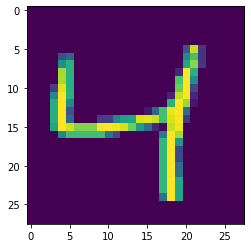

target: 4 predicted: 4


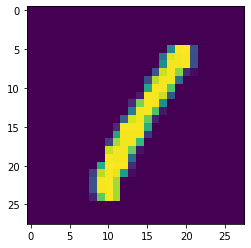

target: 1 predicted: 1


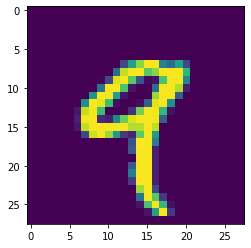

target: 9 predicted: 9


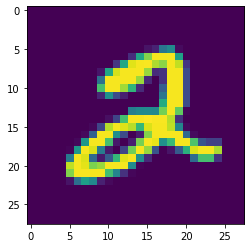

target: 2 predicted: 9


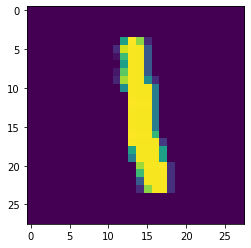

target: 1 predicted: 1


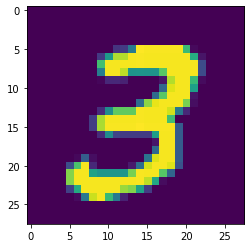

target: 3 predicted: 3


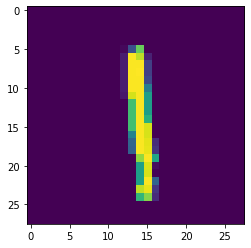

target: 1 predicted: 1


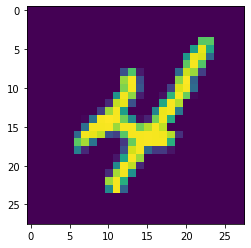

target: 4 predicted: 4


In [23]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, gradient):
        for l in self.layers[::-1]:
            gradient = l.backward(gradient)

        return gradient

# values to map [0,1]
simple = transforms.Compose([
    transforms.ToTensor(), 
])

ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(5):
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()

        res = mm(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean()
        gradient = loss.backward(1)
        mm.backward(gradient)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')
            
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )